# Data input
- We will first import the necessary Python packages
- We will then load our datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# # The default matplotlib style is a bit ugly. Seaborn provides a nicer style sheet that integrates with matplotlib.
# sns.set()  # use Seaborn styles. 

In [3]:
df_hh = pd.read_csv('../Data/NHTS/hhpub.csv') # import the household data
df_per = pd.read_csv('../Data/NHTS/perpub.csv') # import the person data
df_trip = pd.read_csv('../Data/NHTS/trippub.csv') # import the trip data
df_veh = pd.read_csv('../Data/NHTS/vehpub.csv') # import the vehicle data

In [4]:
df_hh.head()

,HOUSEID,TRAVDAY,SAMPSTRAT,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,PC,SPHONE,TAB,...,SMPLSRCE,WTHHFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,2,3,1,3,5,7,2,1,2,...,2,187.314320,T,50,1500,750,750,20,750,300
1,30000008,5,2,1,2,4,8,1,1,2,...,2,69.513032,R,5,300,300,150,5,300,300
2,30000012,5,3,1,1,2,10,1,1,3,...,2,79.419586,C,80,17000,17000,5000,60,17000,7000
3,30000019,5,3,1,2,2,3,1,5,5,...,2,279.143588,S,40,300,300,150,50,750,300
4,30000029,3,3,1,2,2,5,2,5,1,...,2,103.240304,S,40,1500,750,750,40,1500,750


# Basic data exploration
Let's first take a look at the trip data and generate some basic statistics.

In [36]:
df_trip.groupby('TRIPPURP').count()['HOUSEID'] # Trip count by purpose

TRIPPURP
-9              32
HBO         190022
HBSHOP      195188
HBSOCREC    110235
HBW         117368
NHB         310727
Name: HOUSEID, dtype: int64

Let's remove trips with the unknown purpose code (-9) and summarize the results as a percent rather than a count.

In [37]:
(df_trip[df_trip.TRIPPURP!="-9"].groupby('TRIPPURP').count()['HOUSEID']/df_trip.shape[0])*100

TRIPPURP
HBO         20.574682
HBSHOP      21.134032
HBSOCREC    11.935723
HBW         12.708051
NHB         33.644047
Name: HOUSEID, dtype: float64

Trip distance frequency in bins

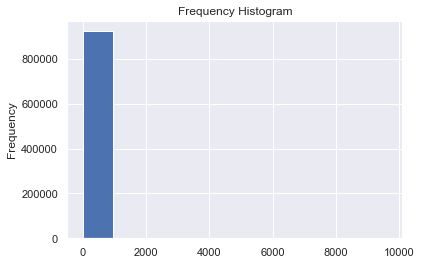

In [38]:
plt.hist(df_trip.TRPMILAD, bins=10);
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [39]:
df_trip.TRPMILAD.describe() # Print basic statistics about a column

count    923572.000000
mean         12.367471
std          75.795664
min          -9.000000
25%           1.468587
50%           3.796943
75%           9.622891
max        9621.053000
Name: TRPMILAD, dtype: float64

This is not a great diagram because it shows one large bar and many small bars. This is because the histogram default is equal width bins. We can define custom bins.

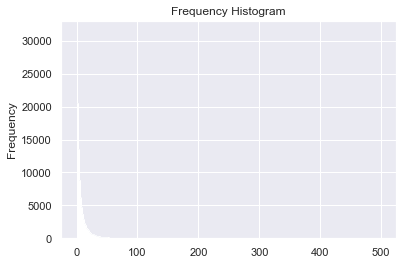

In [40]:
plt.hist(df_trip[(df_trip.TRPMILAD>0) & (df_trip.TRPMILAD<500) ].TRPMILAD, bins='fd');
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

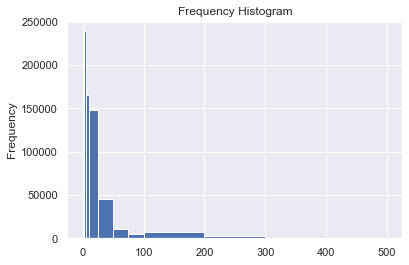

In [41]:
plt.hist(df_trip[(df_trip.TRPMILAD>0) & (df_trip.TRPMILAD<500) ].TRPMILAD, bins=[0,1,2,5,10,25,50,75,100,200,300,400,500]);
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

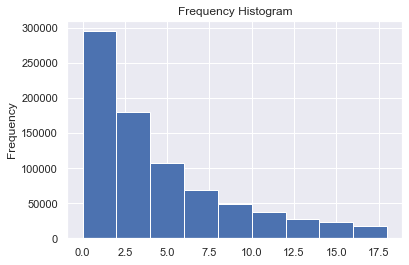

In [42]:
plt.hist(df_trip[(df_trip.TRPMILAD>0) & (df_trip.TRPMILAD<500) ].TRPMILAD, bins=list(range(0,20,2)));
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

# Join Data and Perform More Analysis
Often we are interested in a combination of attributes on trips, persons, households, vehicles, etc. We can join datatables on common columns and perform additional analysis.

In [5]:
cols_to_use = df_per.columns.difference(df_trip.columns) # Filter out only the non-common columns
df_trip = df_trip.join(df_per[cols_to_use],on='PERSONID') # Join trip datatable with person datatable (shorthand for merge() with inner join)
pd.set_option('display.max_rows', None) # Display all rows

df_trip.groupby(['R_AGE_IMP','TRPTRANS']).count()['PERSONID']

R_AGE_IMP  TRPTRANS
5           1           517
            2            79
            3          1896
            4          2267
            5          1154
            6           455
            7             5
            9             5
            10          546
            11           28
            13           19
            15            2
            16            6
            17            6
            18            5
            19            6
            20            4
            97           20
6          -8             2
            1           604
            2            68
            3          1794
            4          2070
            5          1151
            6           449
            7             7
            10          674
            11           19
            13           18
            16            7
            17            7
            18            7
            19            3
            20            4
            97           12


In [6]:
df_trip.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,W_CHAIR,W_CRUTCH,W_DOG,W_MTRCHR,W_NONE,W_SCOOTR,W_WHCANE,W_WLKR,YEARMILE,YRTOUS
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,10000,-1
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,10000,-1
2,30000007,2,1,700,900,120,84.004,6,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,1000,-1
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,1000,-1
4,30000007,3,1,845,900,15,2.250,3,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,12000,-1


It may be more useful to bin age into 10 year groups and display the modes as text.

In [44]:
df_trip['AGE_GRP'] = pd.cut(df_trip.R_AGE_IMP,bins=list(range(5,100,10)))
df_trip['MODE_STR'] = df_trip.TRPTRANS.map({-9:"Not ascertained",-8:"I don't know",-7:"I prefer not to answer",
    1:"Walk",2:"Bicycle",3:"Car",4:"SUV",5:"Van",6:"Pickup truck",7:"Golf cart / Segway",8:"Motorcycle / Moped",
    9:"RV (motor home, ATV, snowmobile)",10:"School bus",11:"Public or commuter bus",12:"Paratransit / Dial-a-ride",
    13:"Private / Charter / Tour / Shuttle bus",14:"City-to-city bus (Greyhound, Megabus)",15:"Amtrak / Commuter rail",
    16:"Subway / elevated / light rail / street car",17:"Taxi / limo (including Uber / Lyft)",
    18:"Rental car (Including Zipcar / Car2Go)",19:"Airplane",20:"Boat / ferry / water taxi",97:"Something Else"
})

df_trip.groupby(['AGE_GRP','MODE_STR']).count()['PERSONID'].unstack()

MODE_STR,Airplane,Amtrak / Commuter rail,Bicycle,Boat / ferry / water taxi,Car,"City-to-city bus (Greyhound, Megabus)",Golf cart / Segway,I don't know,I prefer not to answer,Motorcycle / Moped,...,Public or commuter bus,"RV (motor home, ATV, snowmobile)",Rental car (Including Zipcar / Car2Go),SUV,School bus,Something Else,Subway / elevated / light rail / street car,Taxi / limo (including Uber / Lyft),Van,Walk
AGE_GRP,,,,,,,,,,,,,,,,,,,,,
"(5, 15]",67,14,1422,37,20172,3,37,3,0,27,...,276,37,84,19200,8864,201,96,84,9958,6799
"(15, 25]",112,95,704,16,33020,21,12,0,0,159,...,918,53,63,10883,1409,284,343,326,2493,6449
"(25, 35]",219,228,1237,61,48534,13,28,0,0,257,...,1011,43,217,25534,82,292,803,694,5194,11034
"(35, 45]",236,202,1120,64,44719,8,19,0,0,259,...,862,42,300,31824,52,392,565,443,10225,9386
"(45, 55]",395,268,1138,81,59486,30,77,4,2,472,...,1091,99,394,36950,152,726,552,407,8861,11654
"(55, 65]",473,246,1394,101,83240,26,133,4,0,617,...,1380,192,605,48463,132,980,602,471,9534,16888
"(65, 75]",238,77,748,78,68326,12,328,2,0,264,...,766,250,231,40545,73,410,298,275,8390,13115
"(75, 85]",70,15,170,16,30377,6,159,0,0,33,...,238,91,93,12182,3,152,59,93,3987,4447
"(85, 95]",7,1,22,0,7161,1,28,0,0,0,...,46,2,14,1618,0,58,2,14,667,999


One easy way to remove outliers is via a robust sigma-clipping operation. The final line in the below code is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution. We'll remove records with overly long or short travel distances, focusing on trips made by private vehicle.

In [45]:
auto_trips = df_trip.query('(MODE_STR == "Car") | (MODE_STR == "SUV") | (MODE_STR == "Van") | (MODE_STR == "Pikcup truck")')
print("Rows before outlier removal:" , auto_trips.shape[0])
quartiles = np.percentile(auto_trips['TRPMILAD'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
auto_trips_remove_outliers = auto_trips.query('(TRPMILAD > @mu - 5 * @sig) & (TRPMILAD < @mu + 5 * @sig)')
print("Rows after outlier removal:" , auto_trips_remove_outliers.shape[0])

Rows before outlier removal: 686860
Rows after outlier removal: 652929


Let's take a look at the number of trips by day of the week and trip purpose.

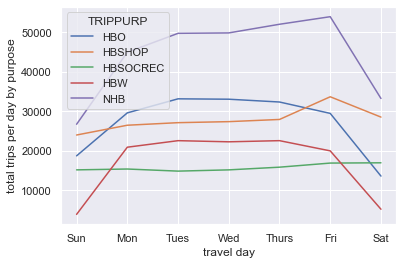

In [46]:
DOW_dict = {1:"Sun",2:"Mon",3:"Tues",4:"Wed",5:"Thurs",6:"Fri",7:"Sat"}
df_trip[df_trip!="-9"].sort_values(by="TRAVDAY").replace({"TRAVDAY":DOW_dict}).pivot_table('TDCASEID', index='TRAVDAY',
                    columns='TRIPPURP', aggfunc='count',sort=False).plot()
plt.ylabel('total trips per day by purpose');
plt.xlabel('travel day');